# Move class into separate species folder

In [7]:
import pandas as pd
import os
import shutil

In [9]:
species_directory = '/users/PAS2186/balasubramaniam29/new/Split_dataset'
det_directory = '/users/PAS2186/balasubramaniam29/new/final_Mar 25/Individual species classifier/dataset'
csv_file_path = 'all_species_info.csv'
df = pd.read_csv(csv_file_path)

for split in os.listdir(species_directory):
    split_path = os.path.join(species_directory, split)
    
    if os.path.isdir(split_path):
        for order in os.listdir(split_path):
            if order in ["Amphibia", "Aves", "Serpentes", "Mammalia"]:
                order_path = os.path.join(split_path, order)

                if os.path.isdir(order_path):
                    for files in os.listdir(order_path):
                        files_path = os.path.join(order_path, files)
                        species_info = df[df['Image Name'] == files]

                        if not species_info.empty:
                            species_name = species_info['Species Name'].values[0]
                            output = os.path.join(det_directory, order, split, species_name)
                            class_path = os.path.join(order_path, species_name)
                            os.makedirs(output, exist_ok=True)

                            destination_image = os.path.join(output, files)
                            shutil.copy(files_path, destination_image)

# Remove some images from Easter Garter Snake

In [22]:
import os
import random
import shutil

def create_subset(source_dir, dest_dir, num_images):
    # Create the destination directory if it doesn't exist
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    # List all files in the source directory
    all_images = os.listdir(source_dir)

    # Randomly select num_images from the list
    selected_images = random.sample(all_images, num_images)

    # Move selected images to the destination directory
    for image in selected_images:
        source_path = os.path.join(source_dir, image)
        dest_path = os.path.join(dest_dir, image)
        shutil.copy(source_path, dest_path)

if __name__ == "__main__":
    # Specify the source directory, destination directory, and the number of images
    source_directory = "/users/PAS2186/balasubramaniam29/new/final_Mar 25/Individual species classifier/dataset/Serpentes/val/Eastern"
    destination_directory = "/users/PAS2186/balasubramaniam29/new/final_Mar 25/Individual species classifier/dataset/Serpentes/val/Eastern Gartersnake"
    num_images_to_select = 100

    # Call the function to create the subset
    create_subset(source_directory, destination_directory, num_images_to_select)


## Split the input dataset into subfolders 

In [30]:
import splitfolders

In [31]:
#Species level
input_folder = '/users/PAS2186/balasubramaniam29/Latest species classifier backup/Sorted_by_species/Serpentes'
splitfolders.ratio(input_folder, 
                           output="/users/PAS2186/balasubramaniam29/new/Individual training/splitimages/Serpentes", 
                           seed=42, 
                           ratio=(.7, .2, .1),
                           group_prefix=None,
                           move=False
                          )

Copying files: 36116 files [14:56, 40.29 files/s]


## Import necessary packages

In [1]:
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
from collections import OrderedDict

import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
#import tensorflow.keras
from PIL import Image, ImageOps
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline
import os


2024-04-01 15:16:08.129140: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-04-01 15:16:08.522649: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-01 15:16:08.522693: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2024-04-01 15:16:10.810624: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directo

In [2]:
image_size = 224
batch_size = 64

In [3]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

# Create image generator

In [4]:
base_dir = '/users/PAS2186/balasubramaniam29/new/final_Mar 25/Individual species classifier/dataset/Aves/'
train_dir = base_dir+ 'train/'
val_dir = base_dir + 'val/'
testing_dir = base_dir + '/test/'
input_shape = (image_size, image_size, 3)

In [5]:
train_datagen = ImageDataGenerator(rescale=1. / 255,
                              height_shift_range= 0.02,
                              width_shift_range=0.02,
                              rotation_range=-0.1,
                              shear_range = 0.01,
                              fill_mode='nearest',
                              zoom_range=0.3,
                              brightness_range=(0.5, 1.5))

In [6]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 16009 images belonging to 6 classes.


In [7]:
test_datagen = ImageDataGenerator(rescale=1. / 255)

test_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='categorical')

Found 2133 images belonging to 6 classes.


In [8]:
testing_datagen = ImageDataGenerator(rescale=1. / 255)

testing_generator = testing_datagen.flow_from_directory(
    testing_dir,
    target_size=(image_size, image_size),
    batch_size=batch_size,
    shuffle=False,
    class_mode='categorical')

Found 3207 images belonging to 6 classes.


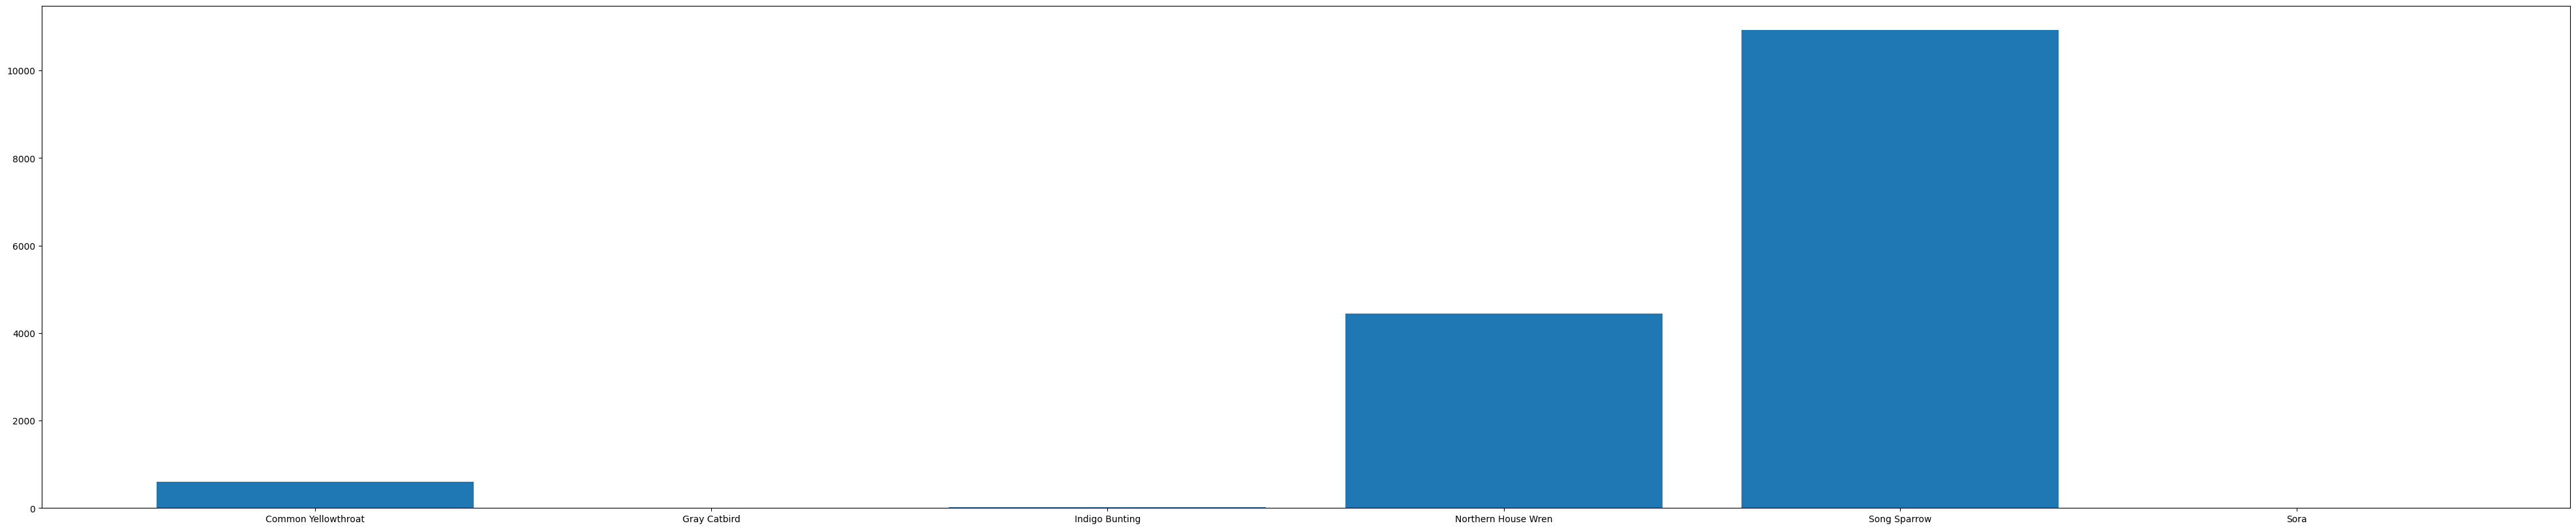

['Common Yellowthroat', 'Gray Catbird', 'Indigo Bunting', 'Northern House Wren', 'Song Sparrow', 'Sora'] [601, 7, 17, 4450, 10925, 9]


In [9]:
cls_train = train_generator.classes
from collections import OrderedDict
classes = list(train_generator.class_indices.keys())

num_values = []
unique, counts = np.unique(cls_train, return_counts=True)
valdict=OrderedDict(zip(unique, counts))
#print(unique, counts)
class_num = len(classes)
for i in range(class_num):
    if i not in valdict:
        valdict[i] = 0
    num_values.append(valdict[i])
plt.figure(figsize=(50,10))
x = np.arange(len(num_values))
xlabel = classes
plt.bar(x, num_values)
plt.xticks(x, xlabel)
plt.show()
print(xlabel, num_values)

In [10]:

# Assuming you have the class labels and indices
classes = list(train_generator.class_indices.keys())

# Get class counts for the train set
cls_train = train_generator.classes
unique_train, counts_train = np.unique(cls_train, return_counts=True)
train_dict = OrderedDict(zip(unique_train, counts_train))

# Get class counts for the test set
cls_test = testing_generator.classes
unique_test, counts_test = np.unique(cls_test, return_counts=True)
test_dict = OrderedDict(zip(unique_test, counts_test))

# Get class counts for the validation set
cls_val = test_generator.classes
unique_val, counts_val = np.unique(cls_val, return_counts=True)
val_dict = OrderedDict(zip(unique_val, counts_val))

for i in range(len(classes)):
    label = classes[i]
    if i not in train_dict:
        train_dict[i] = 0
    if i not in test_dict:
        test_dict[i] = 0
    if i not in val_dict:
        val_dict[i] = 0
        
# Create a table with the counts for each class
table_data = {'Class': classes, 'Train': [], 'Test': [], 'Validation': []}

for label in classes:
    table_data['Train'].append(train_dict[train_generator.class_indices[label]])
    table_data['Test'].append(test_dict[test_generator.class_indices[label]])
    table_data['Validation'].append(val_dict[testing_generator.class_indices[label]])

# Display the table
import pandas as pd
df = pd.DataFrame(table_data)
print(df)


                 Class  Train  Test  Validation
0  Common Yellowthroat    601   121          80
1         Gray Catbird      7     2           1
2       Indigo Bunting     17     4           2
3  Northern House Wren   4450   891         593
4         Song Sparrow  10925  2186        1456
5                 Sora      9     3           1


## Download MobileNetV2 model

In [14]:
pretrained_model = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False)
pretrained_model.summary()

2024-03-31 22:55:59.012649: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-03-31 22:55:59.013586: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-03-31 22:55:59.014156: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-03-31 22:55:59.014725: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-03-31 22:55:59.015283: W tensorfl

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                            

                                                                                                  
 block_3_expand (Conv2D)        (None, None, None,   3456        ['block_2_add[0][0]']            
                                144)                                                              
                                                                                                  
 block_3_expand_BN (BatchNormal  (None, None, None,   576        ['block_3_expand[0][0]']         
 ization)                       144)                                                              
                                                                                                  
 block_3_expand_relu (ReLU)     (None, None, None,   0           ['block_3_expand_BN[0][0]']      
                                144)                                                              
                                                                                                  
 block_3_p

                                192)                                                              
                                                                                                  
 block_6_expand_BN (BatchNormal  (None, None, None,   768        ['block_6_expand[0][0]']         
 ization)                       192)                                                              
                                                                                                  
 block_6_expand_relu (ReLU)     (None, None, None,   0           ['block_6_expand_BN[0][0]']      
                                192)                                                              
                                                                                                  
 block_6_pad (ZeroPadding2D)    (None, None, None,   0           ['block_6_expand_relu[0][0]']    
                                192)                                                              
          

 block_9_expand_BN (BatchNormal  (None, None, None,   1536       ['block_9_expand[0][0]']         
 ization)                       384)                                                              
                                                                                                  
 block_9_expand_relu (ReLU)     (None, None, None,   0           ['block_9_expand_BN[0][0]']      
                                384)                                                              
                                                                                                  
 block_9_depthwise (DepthwiseCo  (None, None, None,   3456       ['block_9_expand_relu[0][0]']    
 nv2D)                          384)                                                              
                                                                                                  
 block_9_depthwise_BN (BatchNor  (None, None, None,   1536       ['block_9_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_12_depthwise (DepthwiseC  (None, None, None,   5184       ['block_12_expand_relu[0][0]']   
 onv2D)                         576)                                                              
                                                                                                  
 block_12_depthwise_BN (BatchNo  (None, None, None,   2304       ['block_12_depthwise[0][0]']     
 rmalization)                   576)                                                              
                                                                                                  
 block_12_depthwise_relu (ReLU)  (None, None, None,   0          ['block_12_depthwise_BN[0][0]']  
                                576)                                                              
                                                                                                  
 block_12_

 onv2D)                         960)                                                              
                                                                                                  
 block_15_depthwise_BN (BatchNo  (None, None, None,   3840       ['block_15_depthwise[0][0]']     
 rmalization)                   960)                                                              
                                                                                                  
 block_15_depthwise_relu (ReLU)  (None, None, None,   0          ['block_15_depthwise_BN[0][0]']  
                                960)                                                              
                                                                                                  
 block_15_project (Conv2D)      (None, None, None,   153600      ['block_15_depthwise_relu[0][0]']
                                160)                                                              
          

"Frozen" all weights pretrained models

In [15]:
pretrained_model.trainable = False

# Created main layers for end MobileNetV2 model

In [16]:
x = pretrained_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(512)(x)
x = BatchNormalization()(x)
x = Activation('relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(class_num, activation='softmax')(x)
model = Model(inputs=pretrained_model.input, outputs=predictions)

View all model before training

In [17]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 Conv1 (Conv2D)                 (None, None, None,   864         ['input_1[0][0]']                
                                32)                                                               
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, None, None,   128         ['Conv1[0][0]']                  
                                32)                                                           

                                                                                                  
 block_3_expand (Conv2D)        (None, None, None,   3456        ['block_2_add[0][0]']            
                                144)                                                              
                                                                                                  
 block_3_expand_BN (BatchNormal  (None, None, None,   576        ['block_3_expand[0][0]']         
 ization)                       144)                                                              
                                                                                                  
 block_3_expand_relu (ReLU)     (None, None, None,   0           ['block_3_expand_BN[0][0]']      
                                144)                                                              
                                                                                                  
 block_3_p

                                192)                                                              
                                                                                                  
 block_6_expand_BN (BatchNormal  (None, None, None,   768        ['block_6_expand[0][0]']         
 ization)                       192)                                                              
                                                                                                  
 block_6_expand_relu (ReLU)     (None, None, None,   0           ['block_6_expand_BN[0][0]']      
                                192)                                                              
                                                                                                  
 block_6_pad (ZeroPadding2D)    (None, None, None,   0           ['block_6_expand_relu[0][0]']    
                                192)                                                              
          

 block_9_expand_BN (BatchNormal  (None, None, None,   1536       ['block_9_expand[0][0]']         
 ization)                       384)                                                              
                                                                                                  
 block_9_expand_relu (ReLU)     (None, None, None,   0           ['block_9_expand_BN[0][0]']      
                                384)                                                              
                                                                                                  
 block_9_depthwise (DepthwiseCo  (None, None, None,   3456       ['block_9_expand_relu[0][0]']    
 nv2D)                          384)                                                              
                                                                                                  
 block_9_depthwise_BN (BatchNor  (None, None, None,   1536       ['block_9_depthwise[0][0]']      
 malizatio

                                                                                                  
 block_12_depthwise (DepthwiseC  (None, None, None,   5184       ['block_12_expand_relu[0][0]']   
 onv2D)                         576)                                                              
                                                                                                  
 block_12_depthwise_BN (BatchNo  (None, None, None,   2304       ['block_12_depthwise[0][0]']     
 rmalization)                   576)                                                              
                                                                                                  
 block_12_depthwise_relu (ReLU)  (None, None, None,   0          ['block_12_depthwise_BN[0][0]']  
                                576)                                                              
                                                                                                  
 block_12_

 onv2D)                         960)                                                              
                                                                                                  
 block_15_depthwise_BN (BatchNo  (None, None, None,   3840       ['block_15_depthwise[0][0]']     
 rmalization)                   960)                                                              
                                                                                                  
 block_15_depthwise_relu (ReLU)  (None, None, None,   0          ['block_15_depthwise_BN[0][0]']  
                                960)                                                              
                                                                                                  
 block_15_project (Conv2D)      (None, None, None,   153600      ['block_15_depthwise_relu[0][0]']
                                160)                                                              
          

# Train a composite neural network based on MobileNetV2 model

In [ ]:
import math
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=["accuracy"])

filepath="inceptionv3_aves.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1,
                             save_best_only=True, mode='min')
learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=10,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)
callbacks_list = [checkpoint, learning_rate_reduction]

steps_per_epoch_train = math.ceil(len(train_generator.filenames) / batch_size)
steps_per_epoch_val = math.ceil(len(test_generator.filenames) / batch_size)
history = model.fit(
    train_generator,
    steps_per_epoch=32,
    validation_data=test_generator,
    validation_steps=5,
    callbacks=callbacks_list,
    epochs=30,
    verbose=1)

Epoch 1/30
32/32 [==============================] - ETA: 0s - loss: 0.8297 - accuracy: 0.7280
Epoch 1: val_loss improved from inf to 0.61217, saving model to inceptionv3_aves.h5
32/32 [==============================] - 215s 6s/step - loss: 0.8297 - accuracy: 0.7280 - val_loss: 0.6122 - val_accuracy: 0.8000 - lr: 0.0010
Epoch 2/30
32/32 [==============================] - ETA: 0s - loss: 0.3573 - accuracy: 0.8730
Epoch 2: val_loss improved from 0.61217 to 0.33072, saving model to inceptionv3_aves.h5
32/32 [==============================] - 209s 6s/step - loss: 0.3573 - accuracy: 0.8730 - val_loss: 0.3307 - val_accuracy: 0.8813 - lr: 0.0010
Epoch 3/30
32/32 [==============================] - ETA: 0s - loss: 0.3098 - accuracy: 0.8926
Epoch 3: val_loss improved from 0.33072 to 0.18797, saving model to inceptionv3_aves.h5
32/32 [==============================] - 190s 6s/step - loss: 0.3098 - accuracy: 0.8926 - val_loss: 0.1880 - val_accuracy: 0.9375 - lr: 0.0010
Epoch 4/30
32/32 [===========

In [11]:
model = load_model('inceptionv3_aves.h5')

2024-04-01 15:16:24.608794: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2024-04-01 15:16:24.609017: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2024-04-01 15:16:24.609239: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2024-04-01 15:16:24.609441: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-04-01 15:16:24.609631: W tensorfl

In [12]:
test_score = model.evaluate_generator(testing_generator, batch_size)

print("[INFO] accuracy: {:.2f}%".format(test_score[1] * 100))
print("[INFO] Loss: ",test_score[0])

[INFO] accuracy: 95.39%
[INFO] Loss:  0.14118851721286774


In [13]:
#Plot the Graph

# Loss Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['loss'],'r',linewidth=3.0)
plt.plot(history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

# Accuracy Curves
plt.figure(figsize=[8,6])
plt.plot(history.history['accuracy'],'r',linewidth=3.0)
plt.plot(history.history['val_accuracy'],'b',linewidth=3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Accuracy',fontsize=16)
plt.title('Accuracy Curves',fontsize=16)

NameError: name 'history' is not defined

<Figure size 800x600 with 0 Axes>

In [14]:
Y_pred = model.predict_generator(testing_generator)
y_pred = np.argmax(Y_pred, axis=1)
cm = confusion_matrix(testing_generator.classes, y_pred)
class_counts = np.bincount(testing_generator.classes)
sorted_indices = np.argsort(class_counts)[::-1]
sorted_classes = [classes[i] for i in sorted_indices]
sorted_cm = cm[:, sorted_indices][sorted_indices, :]
group_counts = ["{0:0.0f}".format(value) for value in sorted_cm.flatten()]
group_percentage = (sorted_cm.T / sorted_cm.sum(axis=1)).T
group_percentages = ["{0:.1%}".format(value) for value in group_percentage.flatten()]
labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_counts, group_percentages)]
labels = np.asarray(labels).reshape(class_num, class_num)

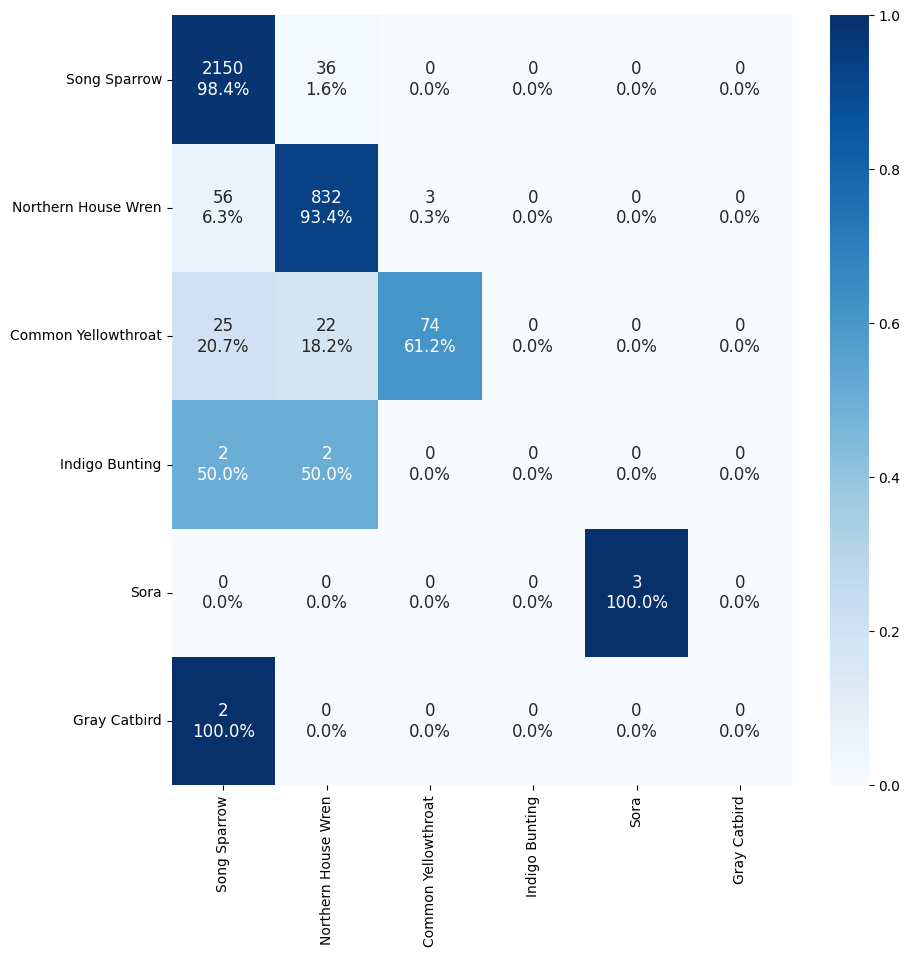

In [15]:
plt.figure(figsize=(10, 10))
heatmap = sns.heatmap(group_percentage, annot=labels, fmt='', cmap='Blues', xticklabels=sorted_classes, yticklabels=sorted_classes,annot_kws={"size": 12})
heatmap.set_yticklabels(heatmap.get_yticklabels(), rotation=0)

plt.show()

In [16]:
print('Classification Report')
print(classification_report(testing_generator.classes, y_pred, target_names=classes))

Classification Report
                     precision    recall  f1-score   support

Common Yellowthroat       0.96      0.61      0.75       121
       Gray Catbird       0.00      0.00      0.00         2
     Indigo Bunting       0.00      0.00      0.00         4
Northern House Wren       0.93      0.93      0.93       891
       Song Sparrow       0.96      0.98      0.97      2186
               Sora       1.00      1.00      1.00         3

           accuracy                           0.95      3207
          macro avg       0.64      0.59      0.61      3207
       weighted avg       0.95      0.95      0.95      3207



# Distribution of human review vs error

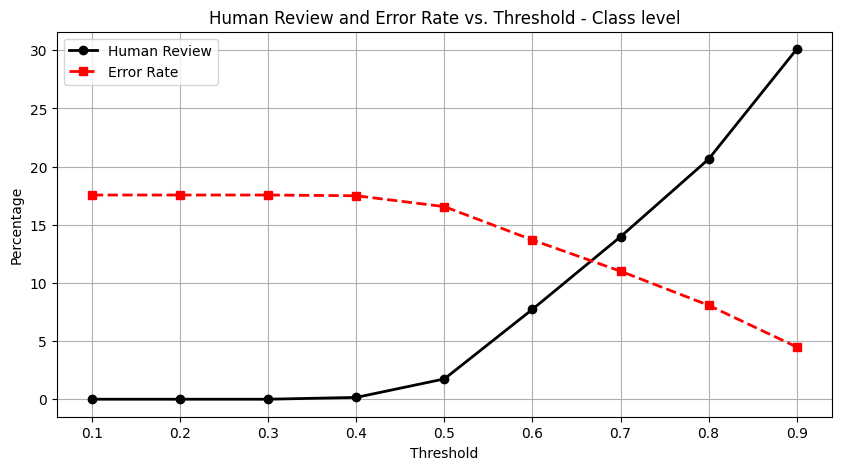

In [31]:
y_true = testing_generator.classes
cm = confusion_matrix(testing_generator.classes, y_pred)
class_counts = np.bincount(y_true)
sorted_indices = np.argsort(class_counts)[::-1]
sorted_classes = [classes[i] for i in sorted_indices]
sorted_cm = cm[:, sorted_indices][sorted_indices, :]

group_counts = ["{0:0.0f}".format(value) for value in sorted_cm.flatten()]
group_percentage = (sorted_cm.T / sorted_cm.sum(axis=1)).T

buckets = [(i / 10.0, (i + 1) / 10.0) for i in range(10)]  # [(0.0, 0.1), (0.1, 0.2), ..., (0.8, 0.9), (0.9, 1.0)]

correct_bucket_counts = {f'{bucket[0]}': 0 for bucket in buckets}
incorrect_bucket_counts = {f'{bucket[0]}': 0 for bucket in buckets}

for i in range(len(y_true)):
    true_label = y_true[i]
    predicted_label = np.argmax(Y_pred[i])
    max_probability = Y_pred[i][predicted_label]
    
    for bucket in buckets:
        if bucket[0] <= max_probability < bucket[1]:
            if true_label == predicted_label:
                correct_bucket_counts[f'{bucket[0]}'] += 1
            else:
                incorrect_bucket_counts[f'{bucket[0]}'] += 1
            break

total_correct = sum(correct_bucket_counts.values())
total_incorrect = sum(incorrect_bucket_counts.values())
total_images = total_correct + total_incorrect

correct_bucket_probabilities = {key: value / total_correct for key, value in correct_bucket_counts.items()}
incorrect_bucket_probabilities = {key: value / total_incorrect for key, value in incorrect_bucket_counts.items()}

thresholds = np.arange(0.9, 0.0, -0.1).round(1)   # Starting from 0.9 and going down to 0.1 in increments of 0.1
human_bucket_probabilities = []
error = []

for threshold_value in thresholds:
    sum_counts_below_threshold = sum(correct_bucket_counts[key] + incorrect_bucket_counts[key] for key in correct_bucket_counts.keys() if float(key) < threshold_value)
    human_bucket_probability = (sum_counts_below_threshold / total_images) * 100
    human_bucket_probabilities.append(human_bucket_probability)
    error_rate = (sum(incorrect_bucket_counts[key] for key in correct_bucket_counts.keys() if float(key) >= threshold_value))/total_images
    error.append(error_rate*100)

plt.figure(figsize=(10, 5))

plt.plot(thresholds, human_bucket_probabilities, marker='o', linestyle='-', linewidth=2, color='black', label='Human Review')
plt.plot(thresholds, error, marker='s', linestyle='--',linewidth=2, color='red', label='Error Rate')

plt.xlabel('Threshold')
plt.ylabel('Percentage')
plt.title('Human Review and Error Rate vs. Threshold - Class level')
plt.legend()
plt.grid(True)
plt.show()


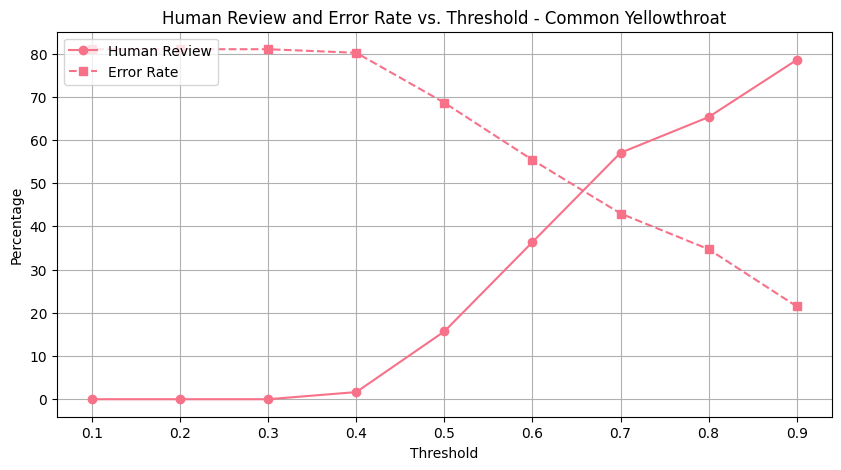

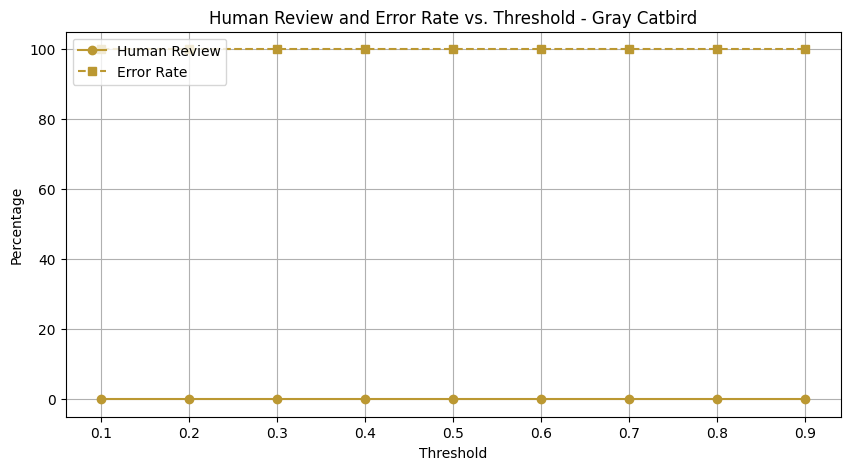

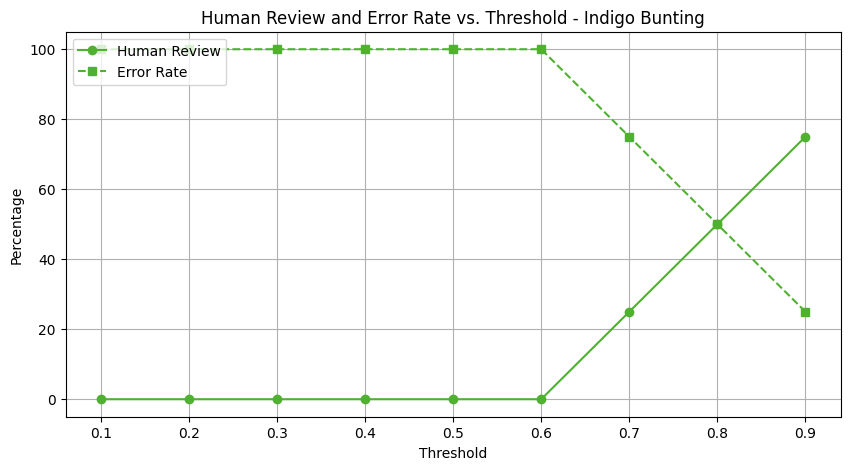

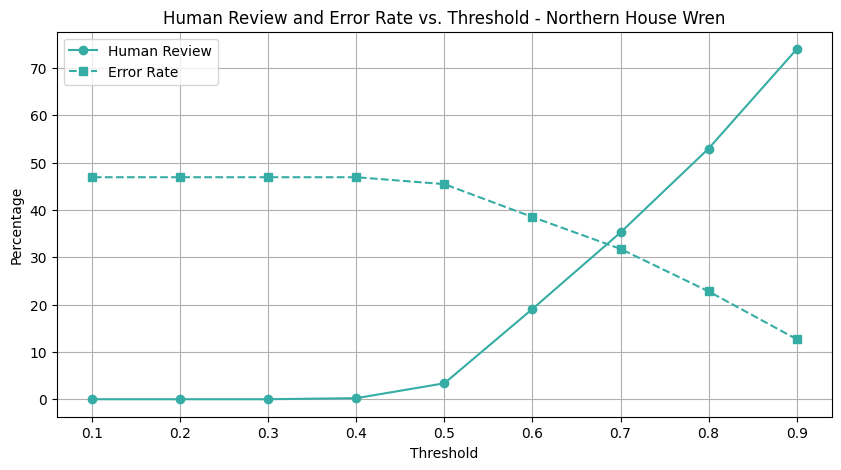

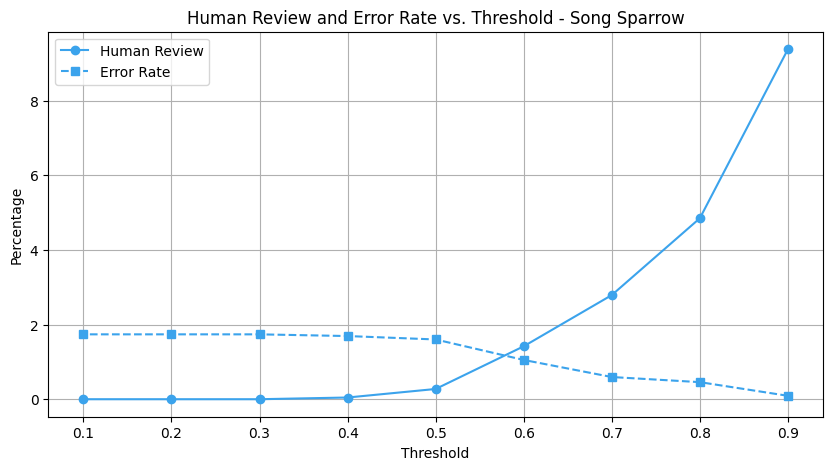

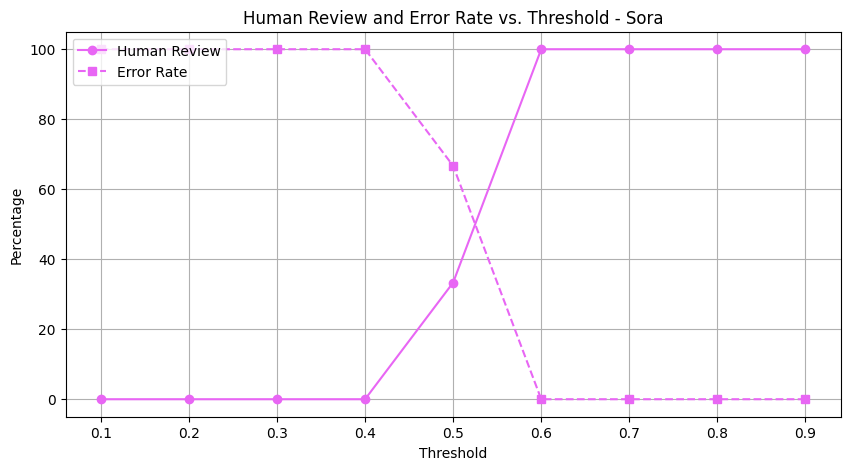

In [32]:
buckets = [(i / 10.0, (i + 1) / 10.0) for i in range(10)]  # [(0.0, 0.1), (0.1, 0.2), ..., (0.8, 0.9), (0.9, 1.0)]
class_colors = sns.color_palette("husl", n_colors=len(sorted_classes))
combined_human_probabilities = []
combined_error_rates = []
for i, label_class in enumerate(range(len(sorted_classes))):
    correct_bucket_counts = {f'{bucket[0]}': 0 for bucket in buckets}
    incorrect_bucket_counts = {f'{bucket[0]}': 0 for bucket in buckets}

    for j in range(len(y_true)):
        true_label = y_true[j]
        predicted_label = np.argmax(Y_pred[j])
        max_probability = Y_pred[j][predicted_label]
        if true_label == label_class:
            for bucket in buckets:
                if bucket[0] <= max_probability < bucket[1]:
                    if true_label == predicted_label:
                        correct_bucket_counts[f'{bucket[0]}'] += 1
                    else:
                        incorrect_bucket_counts[f'{bucket[0]}'] += 1
                    break

    total_correct = sum(correct_bucket_counts.values())
    total_incorrect = sum(incorrect_bucket_counts.values())
    total_images = total_correct + total_incorrect
    correct_bucket_probabilities = {key: value / total_correct if total_correct != 0 else 0 for key, value in correct_bucket_counts.items()}
    incorrect_bucket_probabilities = {key: value / total_incorrect if total_incorrect != 0 else 0 for key, value in incorrect_bucket_counts.items()}
    thresholds = np.arange(0.9, 0.0, -0.1).round(1)   # Starting from 0.9 and going down to 0.1 in increments of 0.1
    human_bucket_probabilities = []
    error = []

    for threshold_value in thresholds:
        sum_counts_below_threshold = sum(correct_bucket_counts[key] + incorrect_bucket_counts[key] for key in correct_bucket_counts.keys() if float(key) < threshold_value)
        human_bucket_probability = (sum_counts_below_threshold / total_images) * 100
        human_bucket_probabilities.append(human_bucket_probability)
        error_rate = (sum(incorrect_bucket_counts[key] for key in correct_bucket_counts.keys() if float(key) >= threshold_value))/total_images
        error.append(error_rate*100)

    plt.figure(figsize=(10, 5))
    plt.plot(thresholds, human_bucket_probabilities, marker='o', linestyle='-', color=class_colors[i], label='Human Review')
    plt.plot(thresholds, error, marker='s', linestyle='--', color=class_colors[i], label='Error Rate')
    plt.xlabel('Threshold')
    plt.ylabel(f'Percentage')
    plt.tick_params(axis='y')
    plt.legend(loc='upper left')
    plt.title(f'Human Review and Error Rate vs. Threshold - {classes[label_class]}')
    plt.grid(True)
    plt.show()

    

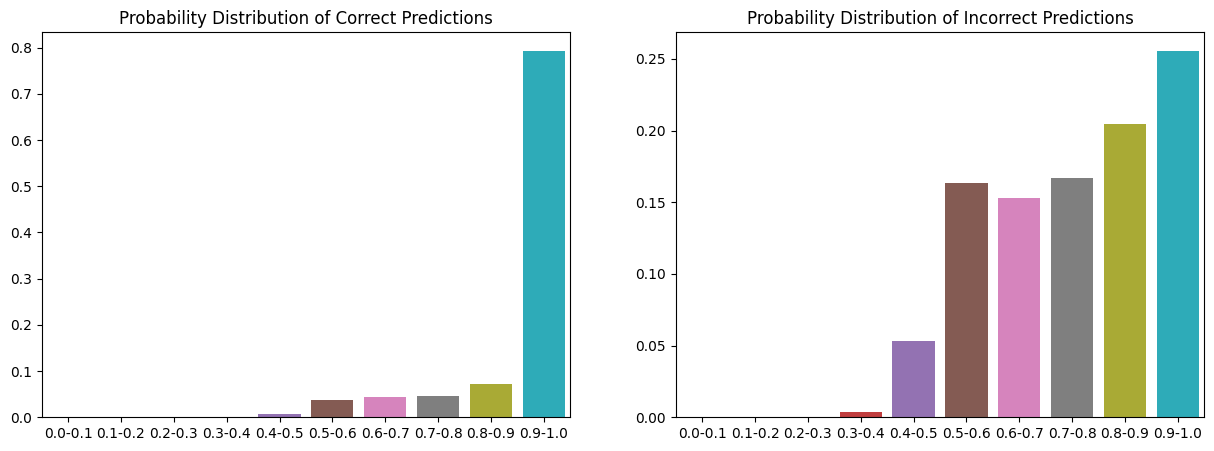

In [33]:
buckets = [(i / 10.0, (i + 1) / 10.0) for i in range(10)]  # [(0.0, 0.1), (0.1, 0.2), ..., (0.8, 0.9), (0.9, 1.0)]

# Classify probabilities into buckets for both correct and incorrect predictions
correct_bucket_counts = {f'{bucket[0]}-{bucket[1]}': 0 for bucket in buckets}
incorrect_bucket_counts = {f'{bucket[0]}-{bucket[1]}': 0 for bucket in buckets}

for i in range(len(y_true)):
    true_label = y_true[i]
    predicted_label = np.argmax(Y_pred[i])
    max_probability = Y_pred[i][predicted_label]
    
    # Determine the probability bucket for the prediction
    for bucket in buckets:
        if bucket[0] <= max_probability < bucket[1]:
            if true_label == predicted_label:
                correct_bucket_counts[f'{bucket[0]}-{bucket[1]}'] += 1
            else:
                incorrect_bucket_counts[f'{bucket[0]}-{bucket[1]}'] += 1
            break

# Calculate the probability distribution of correct and incorrect predictions
total_correct = sum(correct_bucket_counts.values())
total_incorrect = sum(incorrect_bucket_counts.values())

correct_bucket_probabilities = {key: value / total_correct for key, value in correct_bucket_counts.items()}
incorrect_bucket_probabilities = {key: value / total_incorrect for key, value in incorrect_bucket_counts.items()}

# Visualize the results

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.barplot(x=list(correct_bucket_probabilities.keys()), y=list(correct_bucket_probabilities.values()))
plt.title('Probability Distribution of Correct Predictions')

plt.subplot(1, 2, 2)
sns.barplot(x=list(incorrect_bucket_probabilities.keys()), y=list(incorrect_bucket_probabilities.values()))
plt.title('Probability Distribution of Incorrect Predictions')

plt.show()
